### Bidirectional LSTM + Attention Model

A **Bidirectional LSTM with Attention** (BiLSTM-Attention) combines bidirectional LSTM processing with an attention mechanism to enhance sequence modeling. The BiLSTM processes input sequences in both forward (past to future) and backward (future to past) directions, capturing context from preceding and succeeding time steps, while the **attention layer dynamically weighs the importance of each timestep** to focus on degradation patterns most relevant for RUL prediction.

This hybrid approach provides richer sequence understanding than unidirectional LSTMs and better interpretability than standard BiLSTMs alone, as attention highlights critical timesteps (e.g., accelerating wear patterns) rather than treating all equally. Outputs from both LSTM directions are concatenated at each timestep, then attention computes softmax-normalized weights and sums weighted hidden states into a context vector for final RUL prediction.

BiLSTM-Attention excels in RUL prediction by combining bidirectional context awareness with selective focus on informative sequence portions, though it requires complete sequences upfront and has higher computational cost than unidirectional models, making it ideal for offline batch processing of CMAPSS turbine degradation data.


In [1]:
# --- Import additional layers and tools for experimentation ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [4]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [5]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [10]:
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        self.dense = Dense(1, activation='tanh')

    def call(self, inputs):
        attention_scores = self.dense(inputs)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        context_vector = inputs * attention_weights
        output = tf.reduce_sum(context_vector, axis=1)
        return output

def build_bidirectional_attention_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=True),
                     input_shape=input_shape),
        AttentionLayer(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model
model = build_bidirectional_attention_model(input_shape=(X.shape[1], X.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,330 (263.01 KB)

 Trainable params: 67,330 (263.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('/content/drive/MyDrive/PrognosAI_OCT25/Data/models/bidirectional_attention_model.keras', monitor='val_loss', verbose=1
)

In [12]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30
1904/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 20369.3301
Epoch 1: saving model to /content/drive/MyDrive/PrognosAI_OCT25/Data/models/bidirectional_attention_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 20355.4531 - val_loss: 6728.9146 - learning_rate: 0.0010
Epoch 2/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5821.4658
Epoch 2: saving model to /content/drive/MyDrive/PrognosAI_OCT25/Data/models/bidirectional_attention_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 5821.1216 - val_loss: 4194.7822 - learning_rate: 0.0010
Epoch 3/30
1903/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4197.3638
Epoch 3: saving model to /content/drive/MyDrive/PrognosAI_OCT25/Data/models/bidirectional_attention_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 4197.0903 - val_loss: 3778.7759 - learning_rate: 0.0010
Epoch 4/30
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3836.8228
Epoch 4: saving model to /content/drive/MyDrive/

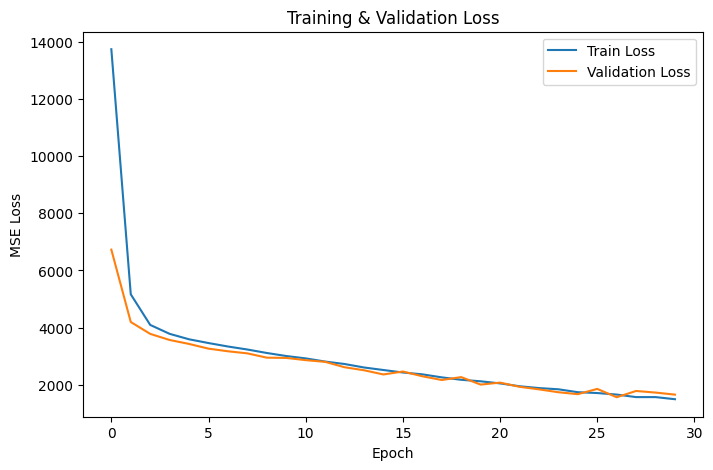

In [13]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


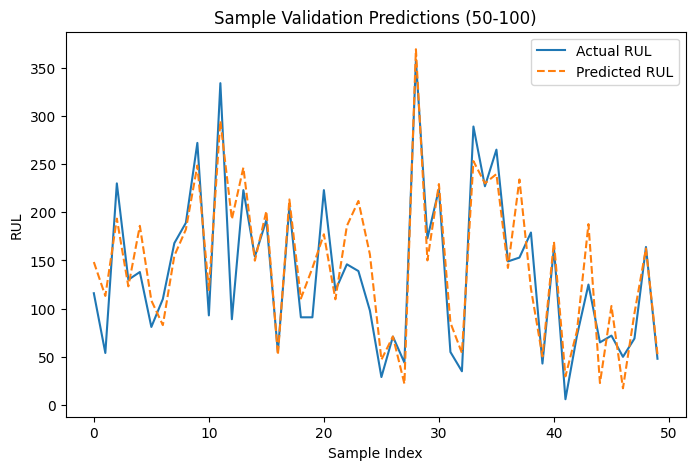

In [14]:
# Verify Model Predictions
val_pred = model.predict(X_val[50:100]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[50:100], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (50-100)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()